In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

In [156]:
# load dataset
from google.colab import drive

drive.mount('/drive')
data = pd.read_csv('/drive/My Drive/Colab Notebooks/Cervical Cancer.csv')
data.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [157]:
data = data.drop(['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes'], axis=1)
data = data.drop(['Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'IUD'], axis=1)
data = data.drop(['IUD (years)', 'STDs', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)
data = data.drop(['STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease'], axis=1)
data = data.drop(['STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:Hepatitis B', 'STDs:HPV'], axis=1)
data.head()

,Age,Hormonal Contraceptives (years),STDs (number),STDs:condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:genital herpes,STDs:HIV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,15,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
2,34,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
3,52,3.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0
4,46,15.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Hormonal Contraceptives (years)     858 non-null    object
 2   STDs (number)                       858 non-null    object
 3   STDs:condylomatosis                 858 non-null    object
 4   STDs:vulvo-perineal condylomatosis  858 non-null    object
 5   STDs:genital herpes                 858 non-null    object
 6   STDs:HIV                            858 non-null    object
 7   STDs: Number of diagnosis           858 non-null    int64 
 8   Dx:Cancer                           858 non-null    int64 
 9   Dx:CIN                              858 non-null    int64 
 10  Dx:HPV                              858 non-null    int64 
 11  Dx                                  858 non-null    int64 

In [158]:
data = data.replace('?', np.nan)

In [159]:
data = data.apply(pd.to_numeric, axis=0)

In [160]:
# Generating list of categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
cat=temp.loc[temp.values < 4].index.to_list()

# Updating null values to the most dominant category:
for factor in cat:
    data[factor] = data[factor].fillna(1)

In [161]:
# Generating list of non-categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
non_cat=temp.loc[temp.values > 3].index.to_list()

# Implementing interpolation (with linear method), on known data for null values:
for factor in non_cat:
    data[factor] = data[factor].fillna(data[factor].median())

In [95]:
len(data)

858

In [162]:
data.drop_duplicates(inplace=True)
len(data)

480

In [97]:
null_perc=data.isnull().sum()/len(data)*100
null=data.isnull().sum()
overview=pd.concat((null,null_perc,data.nunique()),axis=1, keys=['Null counts','Null %','Cardinality'])
overview

,Null counts,Null %,Cardinality
Age,0,0.0,44
Hormonal Contraceptives (years),0,0.0,40
STDs (number),0,0.0,5
STDs:condylomatosis,0,0.0,2
STDs:vulvo-perineal condylomatosis,0,0.0,2
STDs:genital herpes,0,0.0,2
STDs:HIV,0,0.0,2
STDs: Number of diagnosis,0,0.0,4
Dx:Cancer,0,0.0,2
Dx:CIN,0,0.0,2


In [98]:
print(data['STDs (number)'].unique())

[0. 2. 1. 3. 4.]


In [99]:
data['Biopsy'].value_counts()[1]

54

In [163]:
y = data['Biopsy']
X = data.drop('Biopsy',axis=1)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

In [165]:
len(X_val)

96

In [166]:
from imblearn.over_sampling import RandomOverSampler
X_train,y_train=RandomOverSampler().fit_resample(X_train,y_train)

In [167]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
X_train = minmax_scale.fit_transform(X_train)
X_val = minmax_scale.transform(X_val)
X_test = minmax_scale.transform(X_test)

#print(scaler.mean_)
#print(scaler.var_)
print(minmax_scale.data_max_)
print(minmax_scale.data_min_)
print(minmax_scale.scale_)

[84. 30.  3.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.]
[14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0.01428571 0.03333333 0.33333333 1.         1.         1.
 1.         0.5        1.         1.         1.         1.
 1.         1.         1.        ]


In [168]:
from tensorflow.keras import initializers
#initializer = tf.keras.initializers.HeNormal(seed=0)

model = Sequential(
    [
        Dense(5, activation = 'relu', input_shape=[15]),
        Dense(3, activation = 'relu'),
        #Dense(4, activation = 'relu'),
        Dense(1, activation = 'sigmoid'),
        #Dense(8, activation = 'relu', input_shape=[15], kernel_initializer=initializer),
        #Dense(16, activation = 'relu', kernel_initializer=initializer),
        #Dense(8, activation = 'relu', kernel_initializer=initializer),
        #Dense(4, activation = 'relu', kernel_initializer=initializer),
        #Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    ]
)

In [169]:
model.build()

In [170]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 5)                 80        
                                                                 
 dense_21 (Dense)            (None, 3)                 18        
                                                                 
 dense_22 (Dense)            (None, 1)                 4         
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


In [171]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00065),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, 
                        epochs=40, batch_size=16,
                        validation_data=(X_val, y_val), 
                        shuffle=True)

Epoch 1/40
31/31 [==============================] - 1s 7ms/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.7765 - val_accuracy: 0.2083
Epoch 2/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5948 - val_loss: 0.7581 - val_accuracy: 0.3750
Epoch 3/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.6210 - val_loss: 0.7491 - val_accuracy: 0.4896
Epoch 4/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6492 - val_loss: 0.7439 - val_accuracy: 0.5417
Epoch 5/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.7218 - val_loss: 0.7348 - val_accuracy: 0.5938
Epoch 6/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.7016 - val_loss: 0.7354 - val_accuracy: 0.5729
Epoch 7/40
31/31 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.7319 - val_loss: 0.7249 - val_accuracy: 0.6250
Epoch 8/40
31/31 [==

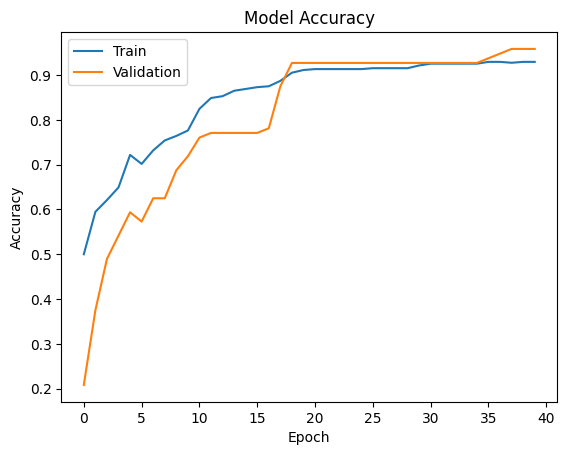

In [172]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

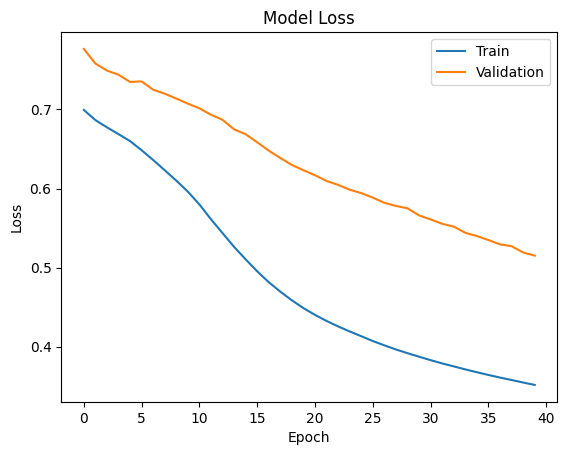

In [173]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [180]:
X_val

array([[0.18571429, 0.01666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.33333333, ..., 1.        , 1.        ,
        0.        ],
       [0.14285714, 0.03333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.38571429, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08571429, 0.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.3       , 0.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [181]:
X_test

array([[0.31428571, 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.01428571, 0.00266667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04285714, 0.00833333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35714286, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38571429, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [174]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

3/3 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.8438
Test loss: 0.6252077221870422
Test accuracy: 0.84375


3/3 [==============================] - 0s 4ms/step

Confusion Matrix


Text(50.722222222222214, 0.5, 'True')

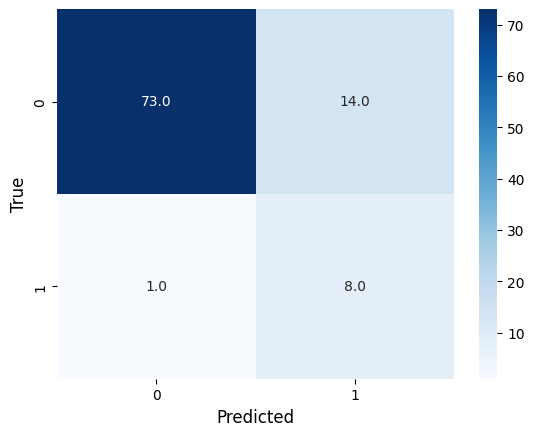

In [175]:
from sklearn.metrics import precision_recall_fscore_support
y_true = y_test
y_pred = model.predict(X_test)

# Make the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.round_(y_true), np.round_(y_pred))
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = ".1f" )
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [176]:
print(classification_report(np.round_(y_true),np.round_(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91        87
           1       0.36      0.89      0.52         9

    accuracy                           0.84        96
   macro avg       0.68      0.86      0.71        96
weighted avg       0.93      0.84      0.87        96



In [177]:
prediction = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [178]:
data_ans = pd.DataFrame({'Biopsy' :y_test})
data_ans['Prediction'] = np.round_(prediction)

In [77]:
data_ans

,Biopsy,Prediction
84,0,0.0
690,0,0.0
666,0,0.0
411,0,1.0
671,1,1.0
...,...,...
317,0,0.0
339,0,0.0
680,0,0.0
26,0,0.0


In [78]:
data_ans[data_ans['Biopsy'] != data_ans['Prediction']]

,Biopsy,Prediction
411,0,1.0
227,0,1.0
756,0,1.0
457,0,1.0
64,1,0.0
719,0,1.0
275,0,1.0
377,1,0.0
646,0,1.0
464,0,1.0


In [79]:
data_ans['Prediction'].value_counts()

0.0    76
1.0    20
Name: Prediction, dtype: int64

In [80]:
data_ans['Biopsy'].value_counts()

0    87
1     9
Name: Biopsy, dtype: int64

In [81]:
print(model.trainable_variables) 

[<tf.Variable 'dense_7/kernel:0' shape=(15, 8) dtype=float32, numpy=
array([[-0.8345158 ,  0.3467878 ,  0.42673692, -0.06231301,  0.41698188,
         0.21207432, -0.46764478,  0.09383165],
       [ 0.55409294,  0.2174316 ,  0.51066566,  0.4793704 ,  0.01598216,
         0.44877654,  0.01880701,  0.3408121 ],
       [ 0.30483177,  0.29140106, -0.3505593 , -0.3126584 ,  0.54804015,
         0.34897125,  0.77087367,  0.5681559 ],
       [-0.5591302 ,  0.3802931 ,  0.5505449 ,  0.3309825 , -0.10871879,
         0.29183334, -0.1839198 ,  0.33167794],
       [ 0.30688554, -0.5996736 ,  0.03946391, -0.34267554, -0.26719254,
        -0.00146349, -0.5167725 ,  0.22688122],
       [ 0.31089407, -0.08872325, -0.18089756, -0.17380345, -0.79117   ,
        -0.23287454,  0.60566574,  0.00828848],
       [-0.288032  ,  0.37009192,  0.13269213, -0.14674973,  0.2890906 ,
         0.35327318,  0.43083245,  0.20939569],
       [-0.53844684, -0.13228764,  0.5860936 , -0.0047018 ,  0.25501224,
        -0.

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
model.save('my_model.h5')

In [ ]:
from google.colab import files

files.download('saved_model/my_model/variables/variables.data-00000-of-00001')
files.download('saved_model/my_model/variables/variables.index')
files.download('saved_model/my_model/fingerprint.pb')
files.download('saved_model/my_model/keras_metadata.pb')
files.download('saved_model/my_model/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pb = tf.saved_model.save(model, "my_model")

In [ ]:
!zip -r my_model .

  adding: .config/ (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2023.05.23/ (stored 0%)
  adding: .config/logs/2023.05.23/13.31.22.234534.log (deflated 56%)
  adding: .config/logs/2023.05.23/13.31.21.581119.log (deflated 57%)
  adding: .config/logs/2023.05.23/13.30.56.681406.log (deflated 58%)
  adding: .config/logs/2023.05.23/13.30.25.094153.log (deflated 58%)
  adding: .config/logs/2023.05.23/13.29.59.526863.log (deflated 91%)
  adding: .config/logs/2023.05.23/13.30.48.984274.log (deflated 86%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/.last_update_check.json (deflated 24%)
  adding: my_model/ (stored 0%)
  adding: my_model/assets/ (stored 0%)
 

In [ ]:
from google.colab import files

files.download('saved_model.zip')

FileNotFoundError: ignored

In [82]:
new_model = tf.keras.models.load_model('my_model.h5')

In [83]:
loss, acc = new_model.evaluate(X_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

3/3 [==============================] - 0s 5ms/step - loss: 0.5599 - accuracy: 0.8542
Restored model, accuracy: 85.42%
